In [55]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys
from sklearn.metrics import pairwise_distances

## Loading data and creating new dataset

In [3]:
df = pd.read_parquet('cleaned_data.parquet')
df = df[df['OrderDate'].dt.year == 2023]
print(df)
print(df.info())

            OrderNumber Company  ArticleID  OrderDate CustomerID  \
0            SGR1300011     AAG  106155952 2023-02-07     147456   
1            SGR1300063     AAG  108629180 2023-04-03     147828   
2            SGR1300011     AAG  108629180 2023-02-07     147456   
3            SGR1300011     AAG  104537470 2023-02-07     147456   
4         RG13000013981     AAG  105840646 2023-02-14     154024   
...                 ...     ...        ...        ...        ...   
24695299       93467411  HENNIG  106612503 2023-12-05    5342371   
24724428       93468134  HENNIG  103810474 2023-10-24   10430827   
24724827       93469920  HENNIG  106612503 2023-10-17    5341011   
24736931       93469905  HENNIG  106612503 2023-10-13    5341011   
24746125       93468112  HENNIG  104222527 2023-06-12    5351310   

             RevenueType  PricePackagingUnit  Quantity  NetRevenue  \
0         Serviceauftrag            0.248691       1.0    0.248691   
1         Serviceauftrag            8.90052

In [4]:
# Calculate unique OrderNumbers
print('unique OrderNumbers =', df['OrderNumber'].nunique())
print('unique ArticleIDs =', df['ArticleID'].nunique())
print('unique SubGroups =', df['ProductSubgroup'].nunique())

# Calculate totalRevenue
totalRevenue = df['NetRevenue'].sum()
print('totalRevenue =', totalRevenue)

unique OrderNumbers = 2427937
unique ArticleIDs = 467865
unique SubGroups = 304
totalRevenue = 67745622.01178011


In [5]:
SubGroupRevenue = df.groupby(['ProductSubgroup', 'State'])['NetRevenue'].sum().reset_index()
SubGroupRevenue['shareOfRevenue'] = (SubGroupRevenue['NetRevenue']/totalRevenue)*100
SubGroupRevenue = SubGroupRevenue.sort_values('shareOfRevenue', ascending=False)
print(SubGroupRevenue.head())

SubGroupRevenue['cumulatedShare'] = np.cumsum(SubGroupRevenue['shareOfRevenue'])
print(SubGroupRevenue.head())

               ProductSubgroup                State    NetRevenue  \
409              BREMSSCHEIBEN  Nordrhein-Westfalen  1.731939e+06   
2950  SONSTIGE KAROSSERIETEILE  Nordrhein-Westfalen  1.547393e+06   
211                  BATTERIEN  Nordrhein-Westfalen  1.493251e+06   
2227                MOTORENÖLE  Nordrhein-Westfalen  1.252020e+06   
263      BELÄGE SCHEIBENBREMSE  Nordrhein-Westfalen  1.014778e+06   

      shareOfRevenue  
409         2.556533  
2950        2.284123  
211         2.204203  
2227        1.848119  
263         1.497924  
               ProductSubgroup                State    NetRevenue  \
409              BREMSSCHEIBEN  Nordrhein-Westfalen  1.731939e+06   
2950  SONSTIGE KAROSSERIETEILE  Nordrhein-Westfalen  1.547393e+06   
211                  BATTERIEN  Nordrhein-Westfalen  1.493251e+06   
2227                MOTORENÖLE  Nordrhein-Westfalen  1.252020e+06   
263      BELÄGE SCHEIBENBREMSE  Nordrhein-Westfalen  1.014778e+06   

      shareOfRevenue  cumulatedS

In [11]:
print(SubGroupRevenue.describe(), '\n\n')
print(SubGroupRevenue.info(), '\n\n')

         NetRevenue  shareOfRevenue  cumulatedShare
count  3.893000e+03     3893.000000     3893.000000
mean   1.740191e+04        0.025687       92.696104
std    7.144603e+04        0.105462       13.770223
min   -2.440347e+04       -0.036022        2.556533
25%    3.410406e+02        0.000503       92.357880
50%    1.891754e+03        0.002792       98.630694
75%    8.974355e+03        0.013247       99.985412
max    1.731939e+06        2.556533      100.150320 


<class 'pandas.core.frame.DataFrame'>
Index: 3893 entries, 409 to 3553
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductSubgroup  3893 non-null   string 
 1   State            3893 non-null   object 
 2   NetRevenue       3893 non-null   float64
 3   shareOfRevenue   3893 non-null   float64
 4   cumulatedShare   3893 non-null   float64
dtypes: float64(3), object(1), string(1)
memory usage: 182.5+ KB
None 




## Visualising ProductSubgroups/cumulatedShare distribution

In [13]:
orders_top25 = df[df['ProductSubgroup'].isin(SubGroupRevenue['ProductSubgroup'])]
print(orders_top25.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12259286 entries, 0 to 24746125
Data columns (total 20 columns):
 #   Column                Dtype         
---  ------                -----         
 0   OrderNumber           string        
 1   Company               string        
 2   ArticleID             int64         
 3   OrderDate             datetime64[ns]
 4   CustomerID            string        
 5   RevenueType           string        
 6   PricePackagingUnit    float64       
 7   Quantity              float64       
 8   NetRevenue            float64       
 9   ProductGroup          string        
 10  ProductSubgroup       string        
 11  BusinessArea          string        
 12  Type                  string        
 13  PostalCode            object        
 14  IndustryGroup         string        
 15  SalesChannelCategory  string        
 16  SalesChannel          string        
 17  Season                string        
 18  State                 object        
 19  Cit

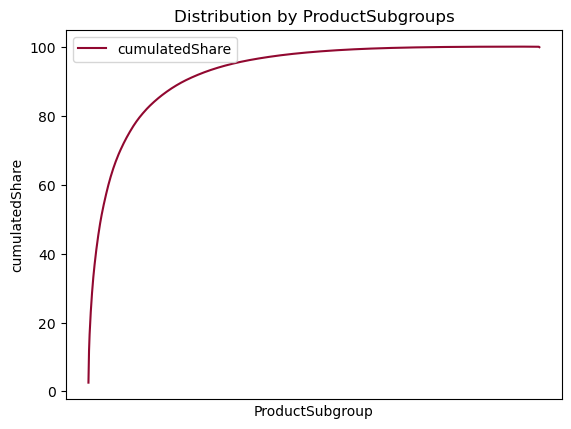

In [16]:
# Plot distribution for all customers by share of revenue

SubGroupRevenue.plot('ProductSubgroup','cumulatedShare', color = (145/255, 8/255, 48/255))
plt.title('Distribution by ProductSubgroups')
plt.xlabel('ProductSubgroup')
plt.ylabel('cumulatedShare')

plt.tick_params(labelbottom = False, bottom = False) 
plt.show()

## Introducing RFM

In [32]:
rfm = pd.DataFrame()

# Timespan since most recent order per ProductSubgroup
reference_time = pd.Timestamp('2023-12-31')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
# Calculating the difference in days from the reference date
orders_top25['daysSinceLastOrder'] = (reference_date - orders_top25['OrderDate']).dt.days
# Finding the most recent order in weeks for each ProductSubgroup
rfmrec = orders_top25.groupby(['ProductSubgroup', 'State'])['daysSinceLastOrder'].min().reset_index()

# Counting of orders per ProductSubgroup
rfmfreq = orders_top25.groupby(['ProductSubgroup', 'State'])['OrderNumber'].count().reset_index()
rfmfreq.columns = ['ProductSubgroup', 'State', 'orderCount']

# Total revenue per ProductSubgroup
rfmmon = orders_top25.groupby(['ProductSubgroup', 'State'])['NetRevenue'].sum().reset_index()
rfmmon.columns = ['ProductSubgroup', 'State', 'sumRevenue']

# Merging features
rfm1 = pd.merge(rfmrec, rfmfreq, on = ['ProductSubgroup', 'State'])
rfm = pd.merge(rfm1, rfmmon, on = ['ProductSubgroup', 'State'])
orders_top25 = orders_top25.drop(['daysSinceLastOrder'], axis=1)

print(rfm.head(), '\n\n')
print(rfm.info(), '\n\n')
print(rfm.describe())

       ProductSubgroup                State  daysSinceLastOrder  orderCount  \
0  1 SÄULEN HEBEBÜHNEN    Baden-Württemberg                  45           5   
1  1 SÄULEN HEBEBÜHNEN               Berlin                 101           1   
2  1 SÄULEN HEBEBÜHNEN  Nordrhein-Westfalen                 313           1   
3  2 SÄULEN HEBEBÜHNEN    Baden-Württemberg                  17          40   
4  2 SÄULEN HEBEBÜHNEN               Bayern                   4          31   

     sumRevenue  
0    738.492147  
1    103.403141  
2    679.973822  
3  21135.520942  
4  17441.726440   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProductSubgroup     3893 non-null   string 
 1   State               3893 non-null   object 
 2   daysSinceLastOrder  3893 non-null   int64  
 3   orderCount          3893 non-null   int64  
 4   sumRevenu

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


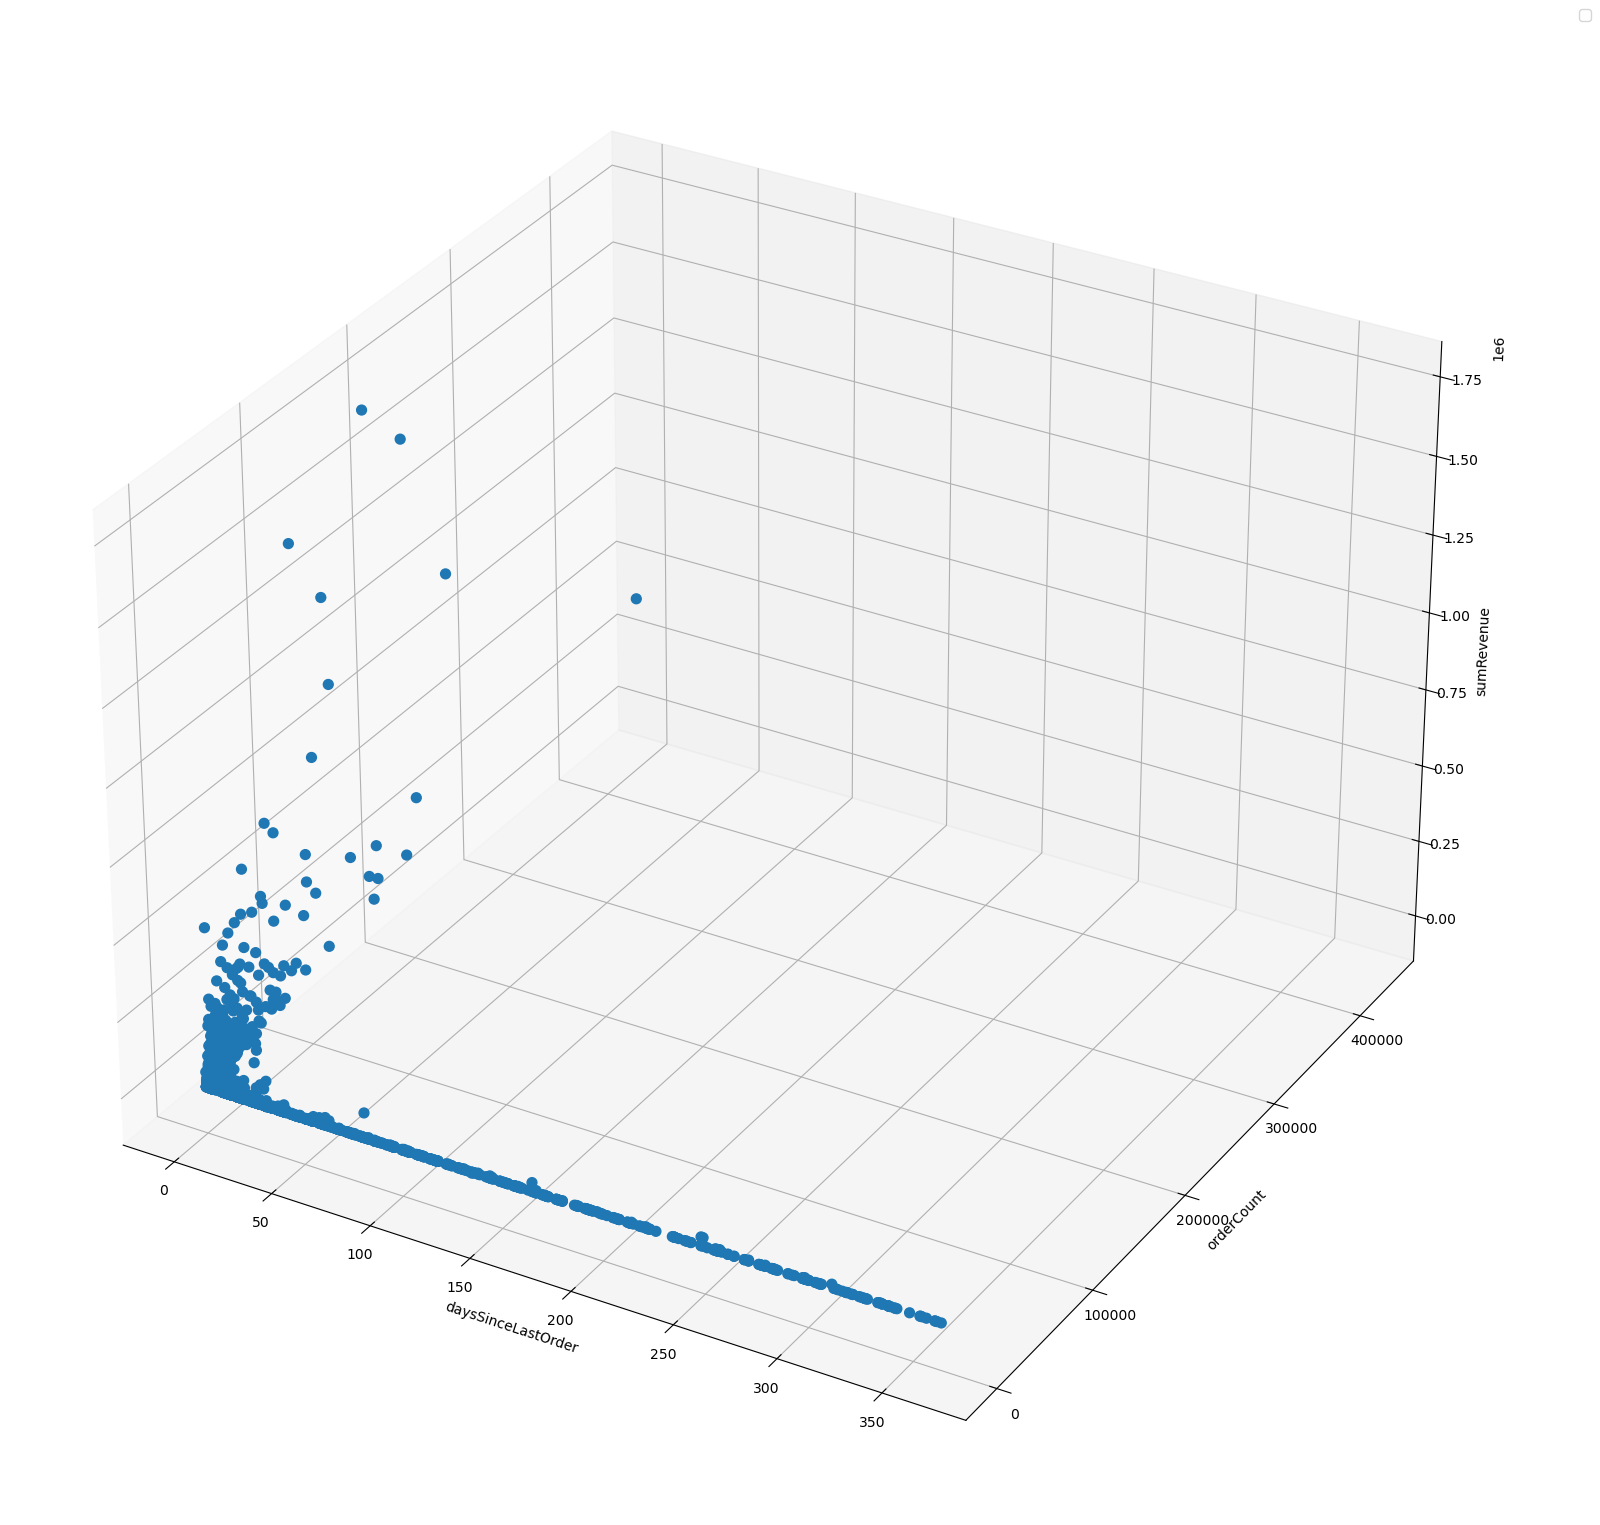

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sn.color_palette("husl", 256).as_hex())

sc = ax.scatter(rfm['daysSinceLastOrder'], rfm['orderCount'], rfm['sumRevenue'], 
                s=50, marker='o', alpha=1)
ax.set_xlabel('daysSinceLastOrder')
ax.set_ylabel('orderCount')
ax.set_zlabel('sumRevenue')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=10)

## k-Means clustering

In [185]:
rfm_clustering = rfm.drop(['ProductSubgroup', 'State'], axis=1)

# Applying scaling
robust_scaler = RobustScaler(quantile_range=(15, 85))

# Results are worse than using Robust option
#yeo_johnson_scaler = PowerTransformer(method="yeo-johnson")

scaled_rfm_np = robust_scaler.fit_transform(rfm_clustering)
scaled_rfm = pd.DataFrame(scaled_rfm_np, columns = rfm_clustering.columns)
print(scaled_rfm.head())

# K-Means Clustering with Silhouette Score
tot_withinss = []
cluster_scores = []
ks = list(range(2, 8))
for k in ks:
    kmeans = KMeans(n_clusters = k, random_state=13, n_init='auto') #test MiniBatchKMeans 
    clusters = kmeans.fit_predict(scaled_rfm)
    score = silhouette_score(scaled_rfm, clusters)
    cluster_scores.append((k, score))
    print(f"Silhouette Score for {k} clusters: {score}")
    tot_withinss.append(kmeans.inertia_)
    

# Getting the best cluster number
best_cluster = max(cluster_scores, key=lambda x: x[1])[0]
print(f"Best top25 cluster number based on Silhouette: {best_cluster}")

   daysSinceLastOrder  orderCount  sumRevenue
0            0.907080   -0.054591   -0.058848
1            2.146018   -0.055906   -0.091255
2            6.836283   -0.055906   -0.061834
3            0.287611   -0.043081    0.981966
4            0.000000   -0.046041    0.793480
Silhouette Score for 2 clusters: 0.949460337771738
Silhouette Score for 3 clusters: 0.9362100479745218
Silhouette Score for 4 clusters: 0.9005983833654179
Silhouette Score for 5 clusters: 0.8418451121024298
Silhouette Score for 6 clusters: 0.6838490847314015
Silhouette Score for 7 clusters: 0.7090065666018609
Best top25 cluster number based on Silhouette: 2


In [183]:
k_means_optimum = KMeans(n_clusters = 5, random_state = 13, n_init = 'auto')
k_means_optimum.fit_predict(scaled_rfm[["daysSinceLastOrder", "orderCount", "sumRevenue"]])
rfm_clustering['Cluster_kmeans'] = k_means_optimum.labels_
rfm_clustering['ProductSubgroup'] = rfm['ProductSubgroup']
rfm_clustering['State'] = rfm['State']
print(rfm_clustering, '\n\n')
print(rfm_clustering['Cluster_kmeans'].value_counts())

      daysSinceLastOrder  orderCount    sumRevenue  Cluster_kmeans  \
0                     45           5    738.492147               0   
1                    101           1    103.403141               0   
2                    313           1    679.973822               0   
3                     17          40  21135.520942               0   
4                      4          31  17441.726440               0   
...                  ...         ...           ...             ...   
3888                   1       36229  34605.480366               4   
3889                   2          95    223.708115               0   
3890                   2        6768   6143.301047               0   
3891                   1       45679  42821.777487               4   
3892                   1        8188   8135.663613               0   

          ProductSubgroup                State  
0     1 SÄULEN HEBEBÜHNEN    Baden-Württemberg  
1     1 SÄULEN HEBEBÜHNEN               Berlin  
2     1 SÄUL

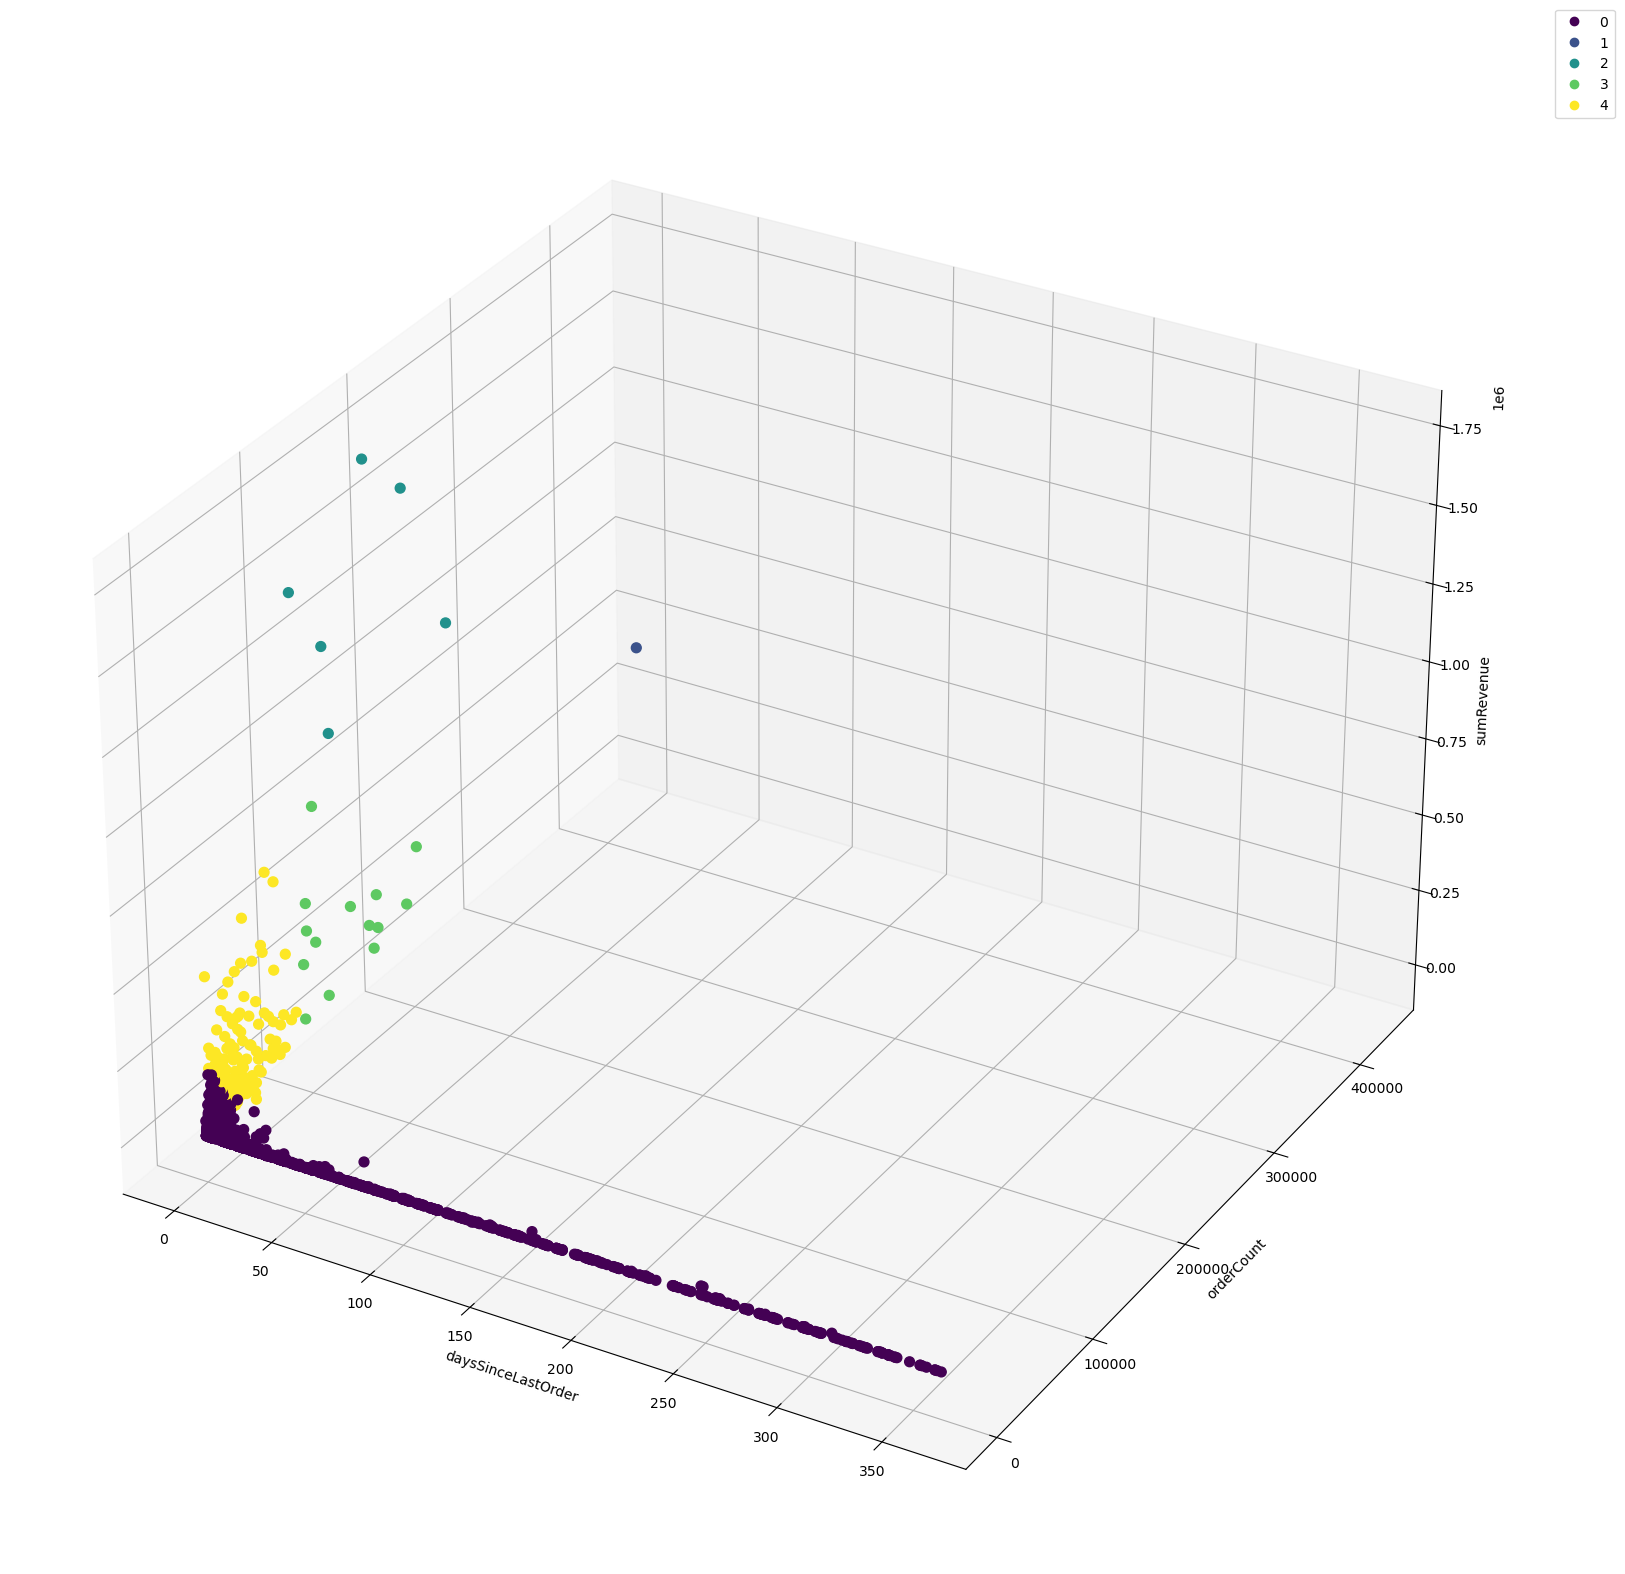

In [167]:
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sn.color_palette("husl", 256).as_hex())

sc = ax.scatter(rfm['daysSinceLastOrder'], rfm['orderCount'], rfm['sumRevenue'], 
                s=50, c=scaled_rfm['Cluster'], marker='o', alpha=1)
ax.set_xlabel('daysSinceLastOrder')
ax.set_ylabel('orderCount')
ax.set_zlabel('sumRevenue')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=10)

## DBSCAN clustering

In [209]:
#t-SNE
tsne = TSNE(n_components=2)
low_vectors_tsne = tsne.fit_transform(scaled_rfm)
print(tsne.kl_divergence_)

#PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_rfm)
print(pca.explained_variance_ratio_)

0.525607705116272
[0.80940951 0.14224981]


[[0.00000000e+00 1.08036678e-03 2.34134010e-02]
 [0.00000000e+00 3.61727789e-03 4.05483331e-03]
 [0.00000000e+00 3.85228104e-02 4.06608763e-02]
 ...
 [0.00000000e+00 3.78344640e-02 1.68309140e-01]
 [0.00000000e+00 1.22369415e+00 1.27162498e+00]
 [0.00000000e+00 1.44738453e-01 2.03433789e-01]] 


(3893, 3) 




<function matplotlib.pyplot.show(close=None, block=None)>

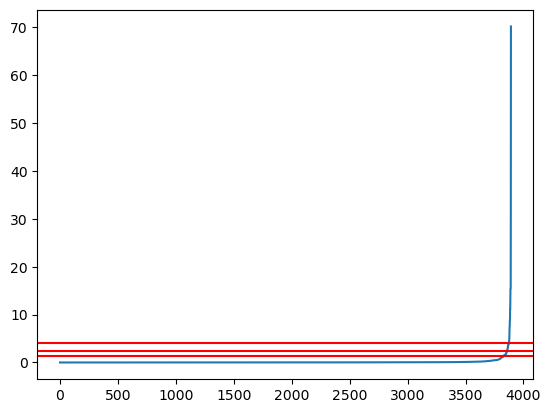

In [267]:
neigh = NearestNeighbors(n_neighbors = 3)
neigh.fit(scaled_rfm)
distances, neighbors = neigh.kneighbors(scaled_rfm)
print(distances, '\n\n')
print(distances.shape, '\n\n')
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)
#plt.xlim(left = 115000)
#plt.ylim(top = 5)
plt.axhline(1.35, color='r')
plt.axhline(2.35, color='r')
plt.axhline(4.0, color='r')
plt.show

In [273]:
#t-SNE DBSCAN

eps_list=np.arange(start=1.0, stop=4.0, step=0.01)
min_sample_list=np.arange(start=2, stop=7, step=1)

silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(low_vectors_tsne)))>1):
            sil_score=silhouette_score(low_vectors_tsne, db.fit_predict(low_vectors_tsne))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(5)) +" min_sample :" + str(min_sample_trial)
        
        #silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))
        silhouette_scores_data=pd.concat([pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]), silhouette_scores_data])

silhouette_scores_data.sort_values(by='score', ascending=False).head(10)

,score,parameters
0,0.384305,eps:1.37 min_sample :6
0,0.383368,eps:1.26 min_sample :6
0,0.383318,eps:1.36 min_sample :6
0,0.382217,eps:1.0 min_sample :3
0,0.380444,eps:1.35 min_sample :6
0,0.380204,eps:1.04 min_sample :4
0,0.380026,eps:1.27 min_sample :6
0,0.378624,eps:1.31 min_sample :6
0,0.378595,eps:1.25 min_sample :6
0,0.377507,eps:1.03 min_sample :4


In [274]:
#PCA DBSCAN

eps_list=np.arange(start=1.0, stop=4.0, step=0.01)
min_sample_list=np.arange(start=2, stop=7, step=1)

silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(pca_components)))>1):
            sil_score=silhouette_score(pca_components, db.fit_predict(pca_components))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(5)) +" min_sample :" + str(min_sample_trial)
        
        #silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))
        silhouette_scores_data=pd.concat([pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]), silhouette_scores_data])

silhouette_scores_data.sort_values(by='score', ascending=False).head(10)

,score,parameters
0,0.958968,eps:3.8 min_sample :3
0,0.958968,eps:3.74 min_sample :3
0,0.958968,eps:3.79 min_sample :3
0,0.958968,eps:3.76 min_sample :3
0,0.958968,eps:3.75 min_sample :3
0,0.958968,eps:3.71 min_sample :3
0,0.958968,eps:3.81 min_sample :3
0,0.958968,eps:3.73 min_sample :3
0,0.958968,eps:3.77 min_sample :3
0,0.958968,eps:3.72 min_sample :3


In [275]:
#Raw dataset DBSCAN

eps_list=np.arange(start=1.0, stop=4.0, step=0.01)
min_sample_list=np.arange(start=2, stop=7, step=1)

silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(scaled_rfm)))>1):
            sil_score=silhouette_score(scaled_rfm, db.fit_predict(scaled_rfm))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(5)) +" min_sample :" + str(min_sample_trial)
        
        #silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]))
        silhouette_scores_data=pd.concat([pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"]), silhouette_scores_data])

silhouette_scores_data.sort_values(by='score', ascending=False).head(10)

,score,parameters
0,0.946298,eps:3.77 min_sample :3
0,0.946298,eps:3.72 min_sample :3
0,0.946298,eps:3.73 min_sample :3
0,0.946298,eps:3.76 min_sample :3
0,0.946298,eps:3.8 min_sample :3
0,0.946298,eps:3.81 min_sample :3
0,0.946298,eps:3.74 min_sample :3
0,0.946298,eps:3.71 min_sample :3
0,0.946298,eps:3.78 min_sample :3
0,0.946298,eps:3.75 min_sample :3


In [375]:
for eps in [8.796551724137931]:
    rfm_clustering[f'dbscan_{eps}'] = DBSCAN(eps=eps, min_samples=5).fit(low_vectors_tsne).labels_

print(rfm_clustering, '\n\n')
print(rfm_clustering['dbscan_8.796551724137931'].value_counts())

      daysSinceLastOrder  orderCount    sumRevenue  dbscan_2.99  dbscan_1.35  \
0                     45           5    738.492147            0            0   
1                    101           1    103.403141            0            0   
2                    313           1    679.973822            0            0   
3                     17          40  21135.520942            0            0   
4                      4          31  17441.726440            0            0   
...                  ...         ...           ...          ...          ...   
3888                   1       36229  34605.480366            0            0   
3889                   2          95    223.708115            0            0   
3890                   2        6768   6143.301047            0            0   
3891                   1       45679  42821.777487            0            6   
3892                   1        8188   8135.663613            0            0   

      dbscan_4.0  dbscan_2.928571428571

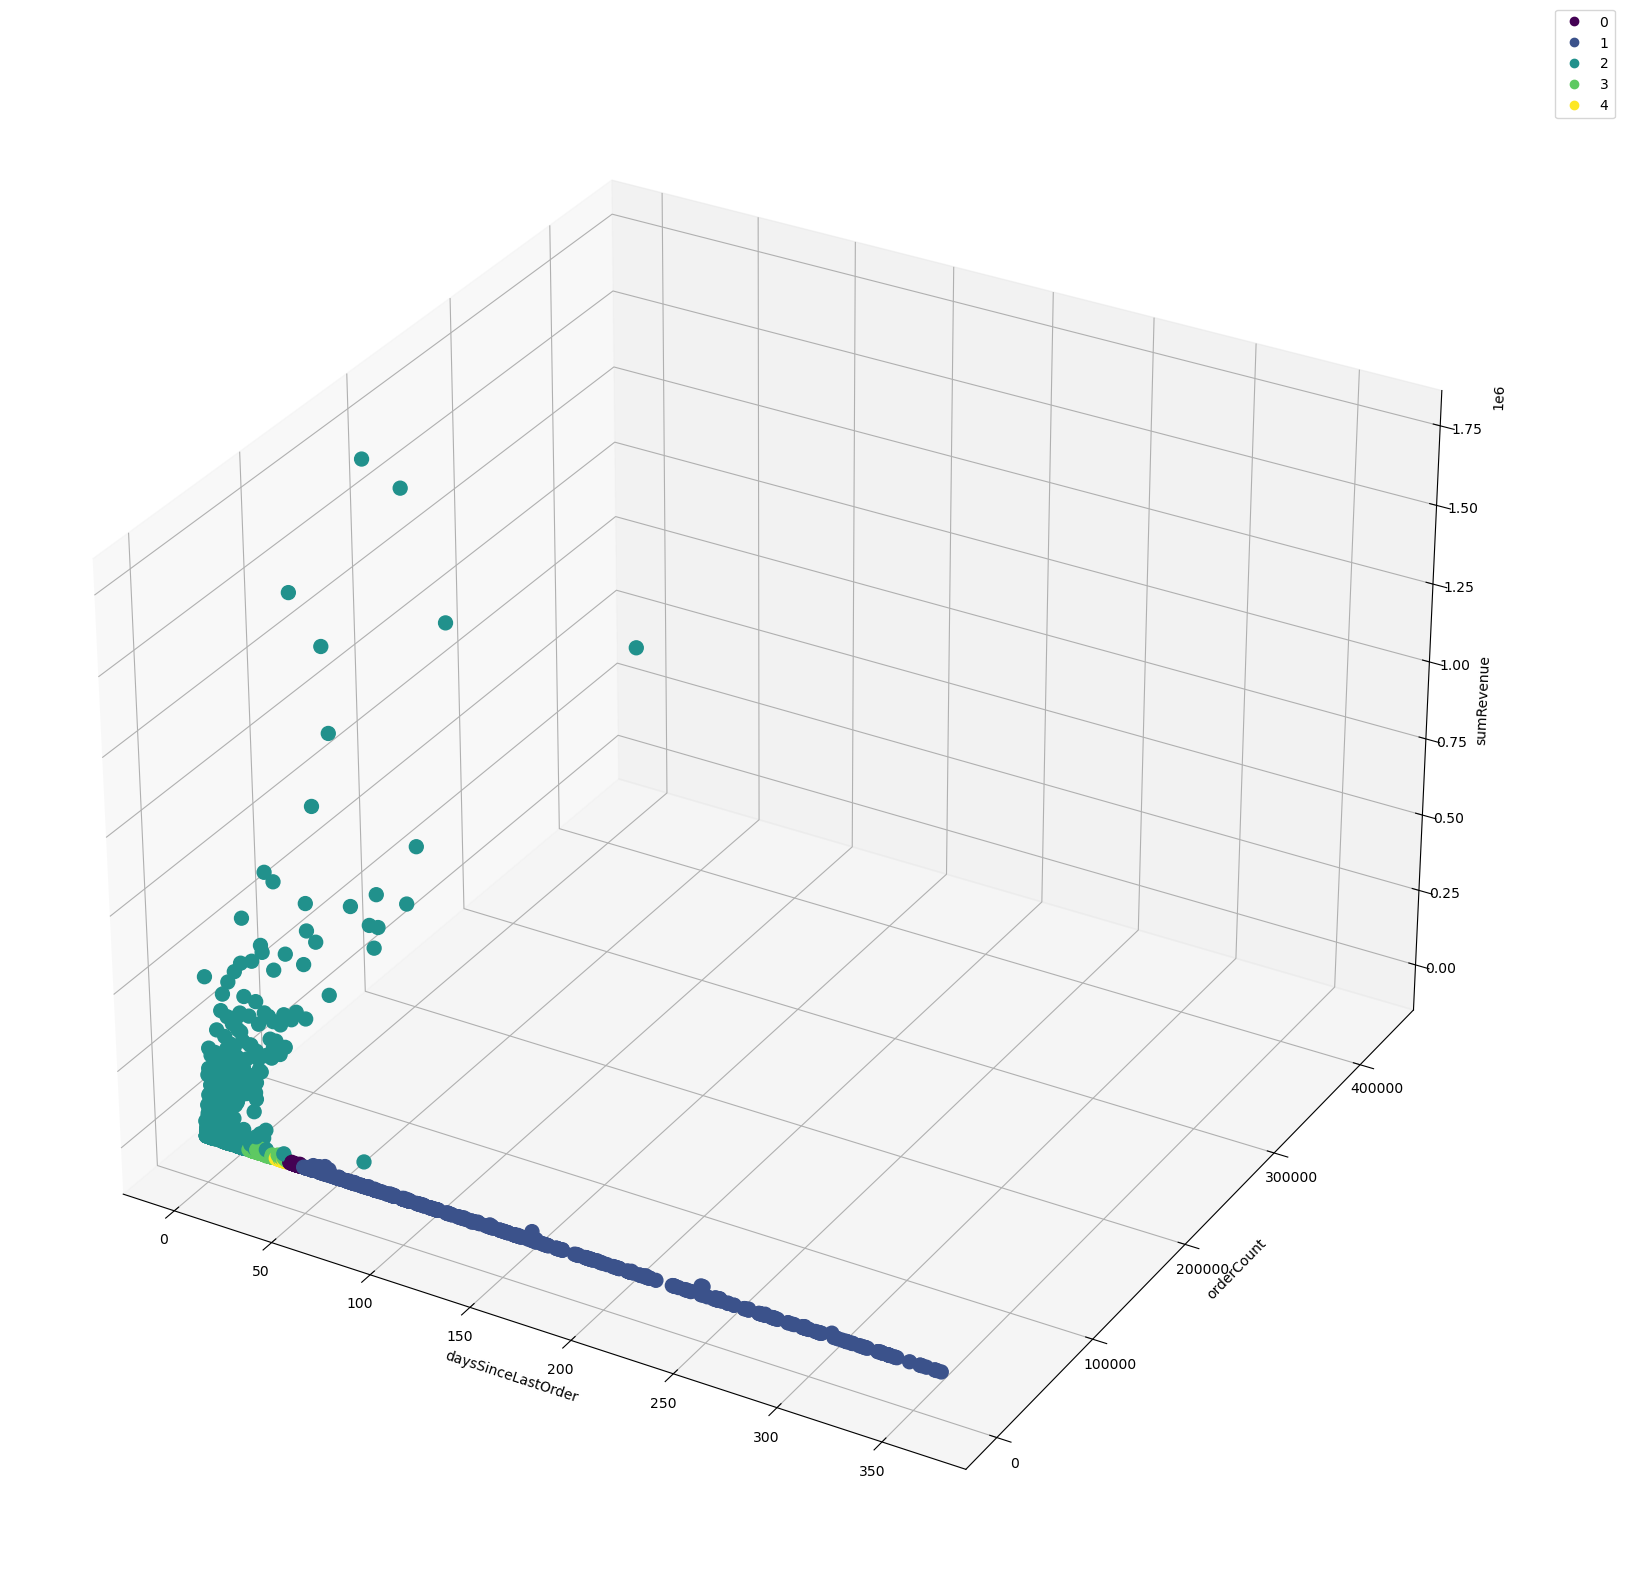

In [377]:
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sn.color_palette("husl", 256).as_hex())

sc = ax.scatter(rfm_clustering['daysSinceLastOrder'], rfm_clustering['orderCount'], rfm_clustering['sumRevenue'], 
                s=100, c = rfm_clustering['dbscan_8.796551724137931'], marker='o', alpha=1)
ax.set_xlabel('daysSinceLastOrder')
ax.set_ylabel('orderCount')
ax.set_zlabel('sumRevenue')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=10)

## DBSCAN tests

In [289]:
## Testing based on YT video
#https://www.youtube.com/watch?v=VO_uzCU_nKw
#https://colab.research.google.com/drive/1DphvjpgQXwBWQq08dMyoSc6UREzXLxSE?usp=sharing#scrollTo=foBuwNA2SL5Z

In [361]:
min_samples = np.arange(2, 7, step=1)
epsilons = np.linspace(3.1, 9.0, num=30)

import itertools

combinations = list(itertools.product(epsilons, min_samples))

N = len(combinations)
combinations

[(3.1, 2),
 (3.1, 3),
 (3.1, 4),
 (3.1, 5),
 (3.1, 6),
 (3.303448275862069, 2),
 (3.303448275862069, 3),
 (3.303448275862069, 4),
 (3.303448275862069, 5),
 (3.303448275862069, 6),
 (3.506896551724138, 2),
 (3.506896551724138, 3),
 (3.506896551724138, 4),
 (3.506896551724138, 5),
 (3.506896551724138, 6),
 (3.7103448275862068, 2),
 (3.7103448275862068, 3),
 (3.7103448275862068, 4),
 (3.7103448275862068, 5),
 (3.7103448275862068, 6),
 (3.913793103448276, 2),
 (3.913793103448276, 3),
 (3.913793103448276, 4),
 (3.913793103448276, 5),
 (3.913793103448276, 6),
 (4.117241379310345, 2),
 (4.117241379310345, 3),
 (4.117241379310345, 4),
 (4.117241379310345, 5),
 (4.117241379310345, 6),
 (4.320689655172414, 2),
 (4.320689655172414, 3),
 (4.320689655172414, 4),
 (4.320689655172414, 5),
 (4.320689655172414, 6),
 (4.524137931034483, 2),
 (4.524137931034483, 3),
 (4.524137931034483, 4),
 (4.524137931034483, 5),
 (4.524137931034483, 6),
 (4.727586206896552, 2),
 (4.727586206896552, 3),
 (4.72758620689

In [363]:
def get_scores_and_labels(combinations, low_vectors_tsne):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(low_vectors_tsne)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1
    
    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue
    
    scores.append(silhouette_score(low_vectors_tsne, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1], 
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, low_vectors_tsne)

Index: 0, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 1, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 2, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 3, Score: 0.0916370078921318, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 4, Score: 0.0916370078921318, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 5, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 6, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 7, Score: 0.044452812522649765, Labels: [0 1 1 ... 8 8 8], NumClusters: 14
Index: 8, Score: 0.0916370078921318, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 9, Score: 0.0916370078921318, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 10, Score: 0.055542945861816406, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 11, Score: 0.055542945861816406, Labels: [0 1 1 ... 8 8 8], NumClusters: 13
Index: 12, Score: 0.05

In [373]:
combinations[143]

(8.796551724137931, 5)

## HDBSCAN test

In [481]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
cluster_labels = clusterer.fit_predict(pca_components)

rfm_clustering['HDBSCAN'] = clusterer.fit(pca_components).labels_

print(rfm_clustering, '\n\n')
print(rfm_clustering['HDBSCAN'].value_counts())

      daysSinceLastOrder  orderCount    sumRevenue  dbscan_2.99  dbscan_1.35  \
0                     45           5    738.492147            0            0   
1                    101           1    103.403141            0            0   
2                    313           1    679.973822            0            0   
3                     17          40  21135.520942            0            0   
4                      4          31  17441.726440            0            0   
...                  ...         ...           ...          ...          ...   
3888                   1       36229  34605.480366            0            0   
3889                   2          95    223.708115            0            0   
3890                   2        6768   6143.301047            0            0   
3891                   1       45679  42821.777487            0            6   
3892                   1        8188   8135.663613            0            0   

      dbscan_4.0  dbscan_2.928571428571

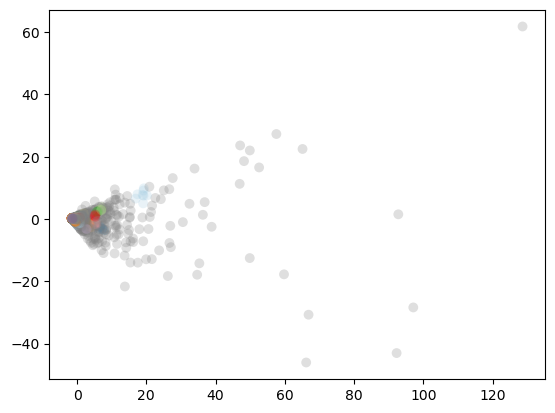

In [483]:
color_palette = sn.color_palette('Paired', 500)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sn.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*pca_components.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

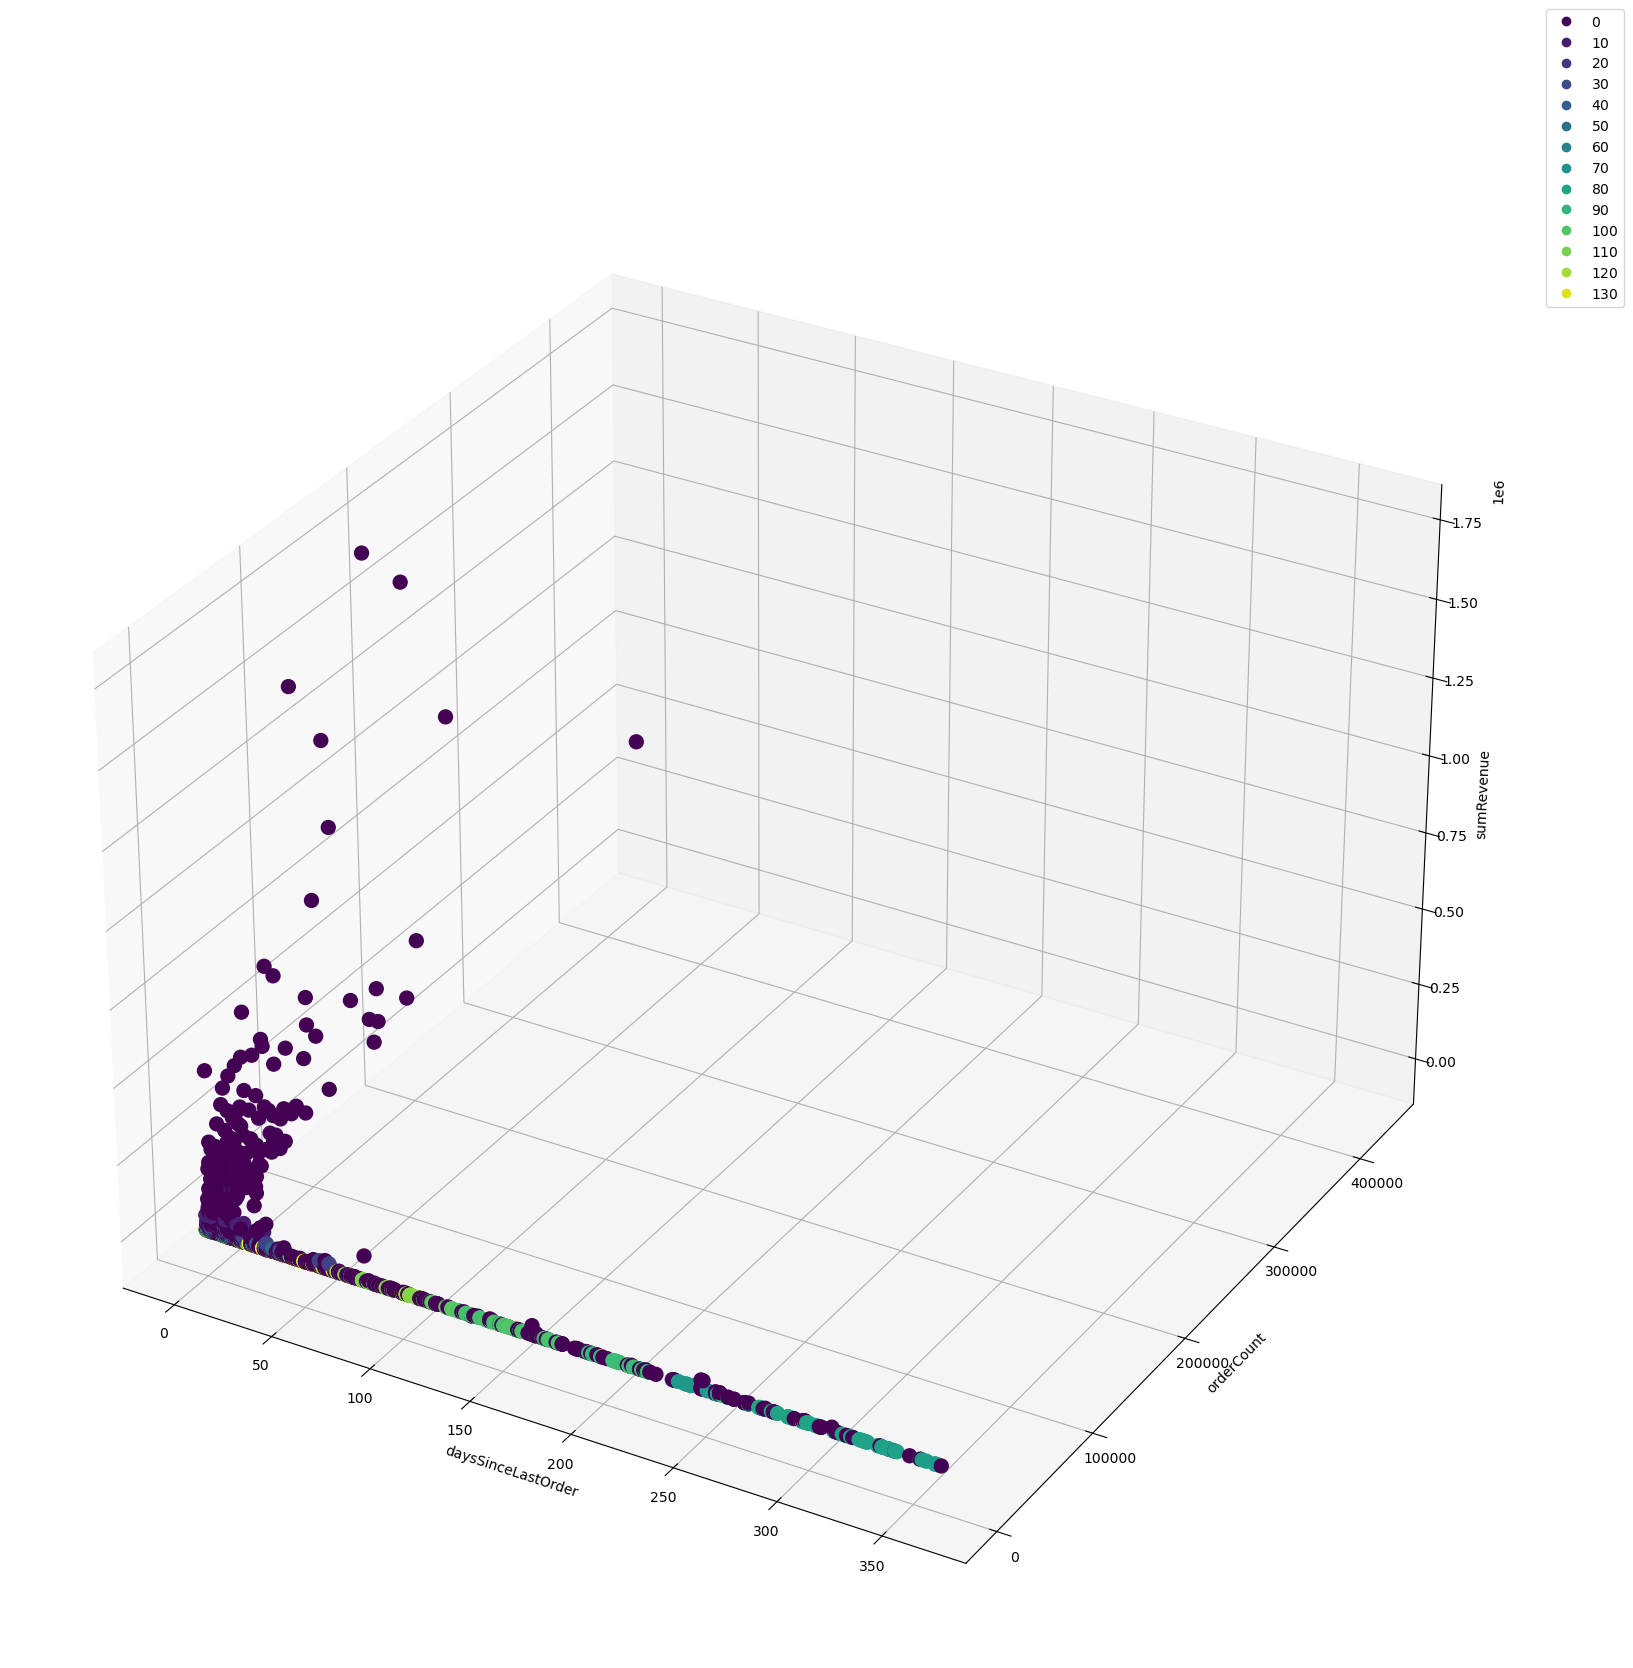

In [485]:
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sn.color_palette("husl", 256).as_hex())

sc = ax.scatter(rfm_clustering['daysSinceLastOrder'], rfm_clustering['orderCount'], rfm_clustering['sumRevenue'], 
                s=100, c = rfm_clustering['HDBSCAN'], marker='o', alpha=1)
ax.set_xlabel('daysSinceLastOrder')
ax.set_ylabel('orderCount')
ax.set_zlabel('sumRevenue')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=10)

<Axes: ylabel='distance'>

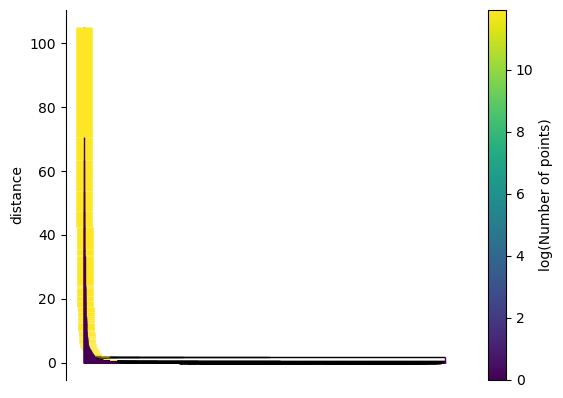

In [453]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

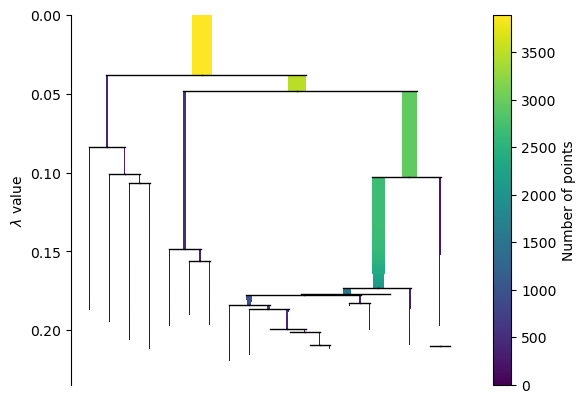

In [426]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

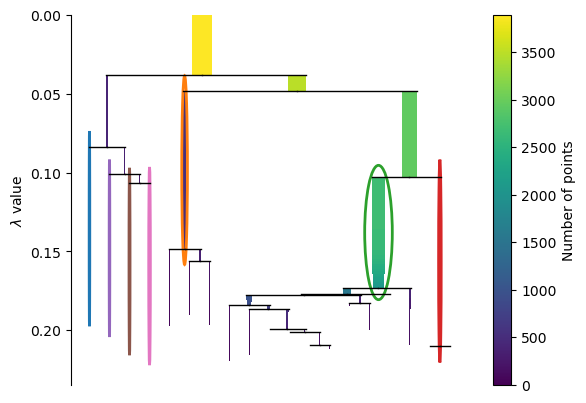

In [427]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sn.color_palette())

## OPTICS test

In [568]:
from sklearn.cluster import OPTICS 

# Initialize the OPTICS clustering model 
optics = OPTICS(min_samples=6, cluster_method='dbscan') 

# Fit the model to the data 
optics.fit(pca_components) 

# Get the cluster labels 
labels = optics.labels_ 

In [569]:
rfm_clustering['OPTICS'] = optics.fit(pca_components).labels_

print(rfm_clustering, '\n\n')
print(rfm_clustering['OPTICS'].value_counts())

      daysSinceLastOrder  orderCount    sumRevenue  dbscan_2.99  dbscan_1.35  \
0                     45           5    738.492147            0            0   
1                    101           1    103.403141            0            0   
2                    313           1    679.973822            0            0   
3                     17          40  21135.520942            0            0   
4                      4          31  17441.726440            0            0   
...                  ...         ...           ...          ...          ...   
3888                   1       36229  34605.480366            0            0   
3889                   2          95    223.708115            0            0   
3890                   2        6768   6143.301047            0            0   
3891                   1       45679  42821.777487            0            6   
3892                   1        8188   8135.663613            0            0   

      dbscan_4.0  dbscan_2.928571428571

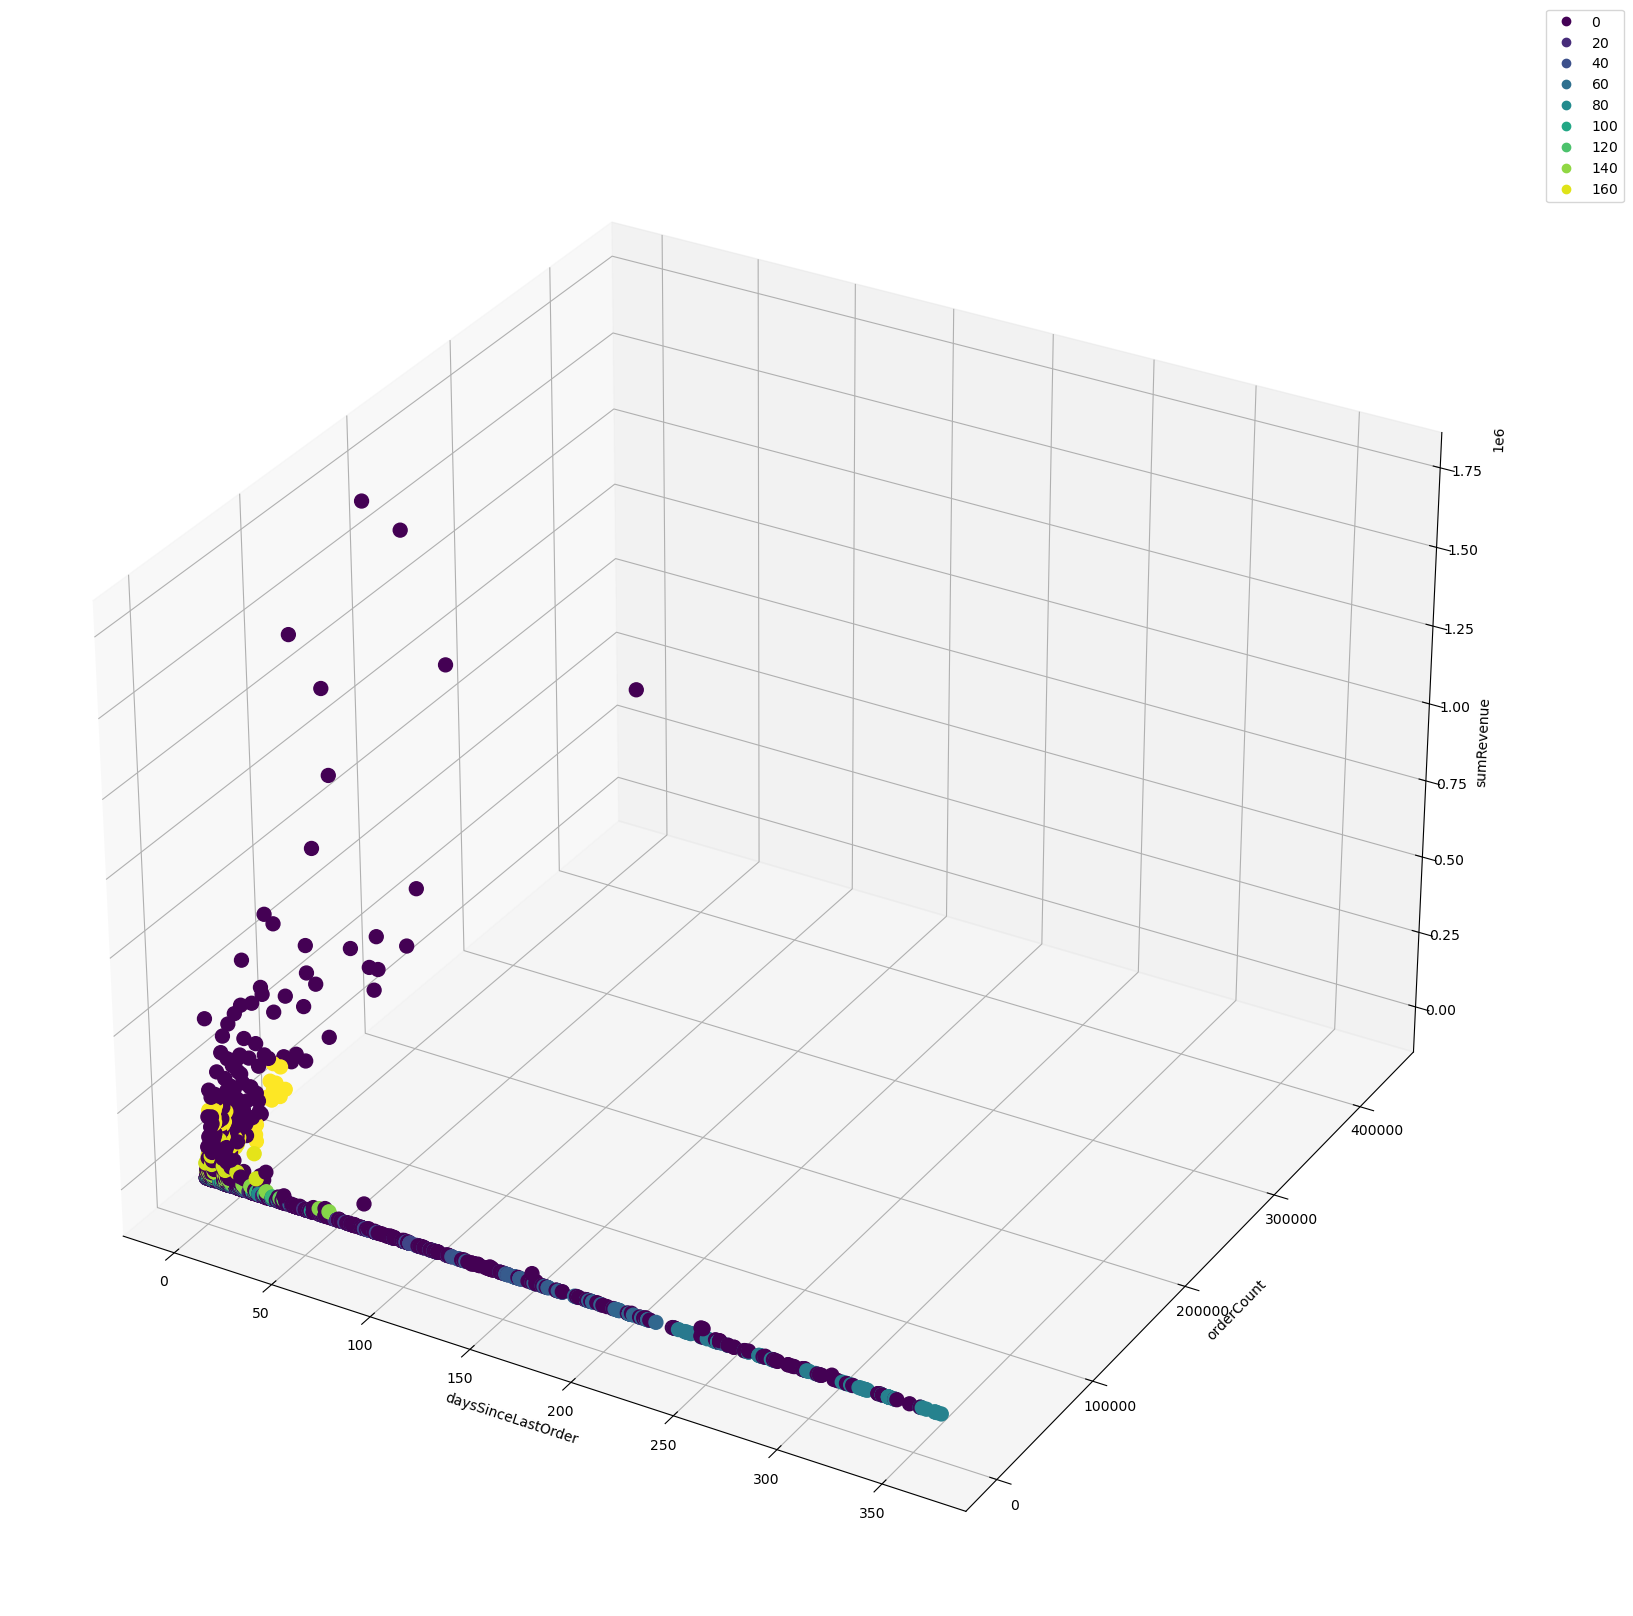

In [508]:
fig = plt.figure(figsize=(15, 15))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sn.color_palette("husl", 256).as_hex())

sc = ax.scatter(rfm_clustering['daysSinceLastOrder'], rfm_clustering['orderCount'], rfm_clustering['sumRevenue'], 
                s=100, c = rfm_clustering['OPTICS'], marker='o', alpha=1)
ax.set_xlabel('daysSinceLastOrder')
ax.set_ylabel('orderCount')
ax.set_zlabel('sumRevenue')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=10)